# Project: Bank Outages vs Sentiment Analysis 

## Hypothesis 
  Bank customer sentiment is impacted by the number of bank outages experienced, this also affects customer satisfaction (and consequently revenue) 

### Operations
#### Twitter data
Twint to scrape tweets of the top 3 banks in South Africa \
Clean tweets with WordPunctTokenizer and Regex \
TextBlog to process sentiment of tweets 
#### Outage data
https://downdetector.co.za/

#### Customer Satisfaction 
Customer satisfaction index by _____


In [1]:
## read Twint quick guide
'''with open("Quick Twint Code.txt","r") as f:
    contents = f.read()
    print(contents)
'''

'with open("Quick Twint Code.txt","r") as f:\n    contents = f.read()\n    print(contents)\n'

In [7]:
import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()            #for compatibility issues with twint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns

#cleaning
import re
from nltk.tokenize import WordPunctTokenizer

# NLP
from textblob import TextBlob

#word cloud and stopwords
from wordcloud import WordCloud, STOPWORDS

### Configure and run Twint (twitter scrapper)

In [3]:
def twintConfig(date_from,search_string):    
    c = twint.Config()
    c.Search = search_string
    c.Pandas = True
    
    #english only
    c.Lang = "en"
    c.Since = date_from
    
    #c.Until = "2021-07-30"
    twint.run.Search(c)
    
#stdBankString = "StandardBankZA OR \"Standard Bank\""
#FNB_String = "FNBSA"

### Run twint

In [4]:
bank_search = {"FNB":"FNBSA", "StandardBank":"StandardBankZA OR \"Standard Bank\""}
since = "2021-09-01"

def Run_Twint(search_vals):
    
    #set empty dataframe
    Final_df= pd.DataFrame()
    
    for bank in search_vals.items():
        print ("running: "+bank[0]+"\n")
        
        #run twint
        twintConfig(since,bank[1])
        
        #get dataframe
        tweets_df = twint.storage.panda.Tweets_df
        
        #join Dataframes and create Bank name column
        tweets_df["Bank"]= bank[0]
        Final_df = pd.concat([Final_df,tweets_df])
    return Final_df

In [ ]:
tweets_df = Run_Twint(bank_search)

## Pandas -  EDA 

In [8]:
#Export to csv
#tweets_df.to_csv("pre_cleaning_en.csv")
tweets_df = pd.read_csv("pre_cleaning_en.csv")

In [9]:
len(tweets_df)

2649

In [10]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2649 entries, 0 to 2648
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2649 non-null   int64  
 1   id               2649 non-null   int64  
 2   conversation_id  2649 non-null   int64  
 3   created_at       2649 non-null   float64
 4   date             2649 non-null   object 
 5   timezone         2649 non-null   int64  
 6   place            1 non-null      object 
 7   tweet            2649 non-null   object 
 8   language         2649 non-null   object 
 9   hashtags         2649 non-null   object 
 10  cashtags         2649 non-null   object 
 11  user_id          2649 non-null   int64  
 12  user_id_str      2649 non-null   int64  
 13  username         2649 non-null   object 
 14  name             2649 non-null   object 
 15  day              2649 non-null   int64  
 16  hour             2649 non-null   int64  
 17  link          

In [11]:
# remove unnecessary rows 
base_tweets = tweets_df[["date", "username", "tweet","language", "hashtags","retweet_id","reply_to" ,"nlikes","search","Bank"]]

### should 'likes' impact sentiment????

 \
.\
.

Come back to this 

In [12]:
base_tweets[base_tweets["nlikes"]>0].sort_values(by = "nlikes").head()

,date,username,tweet,language,hashtags,retweet_id,reply_to,nlikes,search,Bank
13,2021-09-03 08:59:06,Lazzy70892008,@FNBSA Easy Payments and my business has becom...,en,['lovefnb'],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",1,FNBSA,FNB
1675,2021-09-01 09:08:12,Phat_Sii,@FNBSA #LoveFNB Cash@Till has helped me to sav...,en,['lovefnb'],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",1,FNBSA,FNB
1649,2021-09-01 09:14:45,Mbalee__Omuhle,@FNBSA I get to save when I withdraw on a till...,en,['lovefnb'],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",1,FNBSA,FNB
2430,2021-09-01 10:55:23,wendyknowler,@ratshicomes @StandardBankZA Crap timing!,en,[],NaN,"[{'screen_name': 'ratshicomes', 'name': 'Roton...",1,"StandardBankZA OR ""Standard Bank""",StandardBank
1596,2021-09-01 09:28:06,Makopo1,@FNBSA I have my groceries and extra cash or o...,en,['lovefnb'],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",1,FNBSA,FNB


### Language analysis 

Although the language tag doesnt seem to get it right 100% of the time, we will drop these rows everything not:
* und = undefined, this will include just hashtags --- will keep this to include hashtags 
*en = english 

In [13]:
base_tweets["language"].unique()

array(['en', 'und', 'sv', 'is', 'ht', 'fr', 'tl', 'nl', 'in', 'pl', 'sl',
       'ro', 'da', 'cy', 'ja', 'es', 'th', 'it', 'pt'], dtype=object)

In [14]:
# remove all rows where language is not english or undefined
base_tweets = base_tweets[base_tweets["language"].isin([ 'und', 'en'])]

In [15]:
base_tweets["language"].unique()

array(['en', 'und'], dtype=object)

### Remove tweets from Bank owned accounts i.e. FNBSA


In [16]:
# remove rows where username is in bank_search
base_tweets = base_tweets[ ~base_tweets["username"].str.contains('FNB|StandardBank',regex = True)   ]

In [17]:
# reset the index for joining later 
base_tweets.reset_index(inplace=True)
base_tweets.drop("index",axis =1,inplace=True)

### Visualisation pre-clean

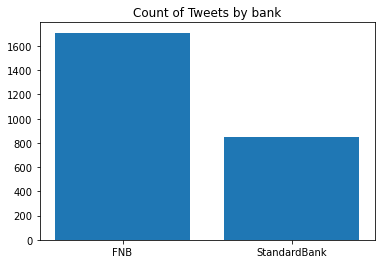

In [19]:
plt.bar(base_tweets["Bank"].value_counts().index, base_tweets["Bank"].value_counts() )
plt.title("Count of Tweets by bank")
plt.show()

### Cleaning tweet data 


In [20]:
def link_at_s_removal(text):  
    pat1 = r'@_?[A-Za-z0-9]+'  # @[A-Za-z0-9]+
    pat2 = r'https?://[A-Za-z0-9./]+'  
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4))
    text = re.sub(combined_pat,"",text)
    return text

def clean_text(text): 
    text=link_at_s_removal(text)
    
    text = re.sub('[^A-Za-z\s]', '', text.lower())        #remove non-alphabet
    tokenized_text = WordPunctTokenizer().tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in STOPWORDS
    ]
    return ' '.join(clean_text)

#### run tween cleaner

In [21]:
cleaned_list = []

for t in base_tweets["tweet"]:
    cleaned_list.append(clean_text(t))

In [22]:
##make a dataframe for sentiment analysis
clean_df = pd.DataFrame(cleaned_list,columns=['tweet'])
clean_df.head()

,tweet
0,really starting frustrate bankers chat helpful
1,
2,dont wait long queues atm bank charges withdra...
3,
4,


In [23]:
#drop empty tweet
clean_df = clean_df [ ~(clean_df["tweet"] =="")]

## Sentiment analysis 

In [24]:
for index, row in clean_df.iterrows():
    tweet = clean_df.at[index, 'tweet']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    clean_df.at[index, 'polarity'] = analysis.sentiment[0]
    clean_df.at[index, 'subjectivity'] = analysis.sentiment[1]


    #Create Positive / negative column depending on polariity
    if analysis.sentiment[0]>0:

        clean_df.at[index, 'Sentiment'] = "Positive"
        #printmd('Positive', color="green")

    elif analysis.sentiment[0]<0:

        clean_df.at[index, 'Sentiment'] = "Negative"
    else:

        clean_df.at[index, 'Sentiment'] = "Neutral"

In [25]:
clean_df.to_csv("cleaned.csv")
clean_df.head()

,tweet,polarity,subjectivity,Sentiment
0,really starting frustrate bankers chat helpful,0.000000,0.100000,Neutral
2,dont wait long queues atm bank charges withdra...,-0.050000,0.400000,Negative
5,easy payment save time,0.433333,0.833333,Positive
6,cant see damn money gone damn sms transactions...,0.000000,0.000000,Neutral
7,dont stand long ques atm less risky cheaper ba...,-0.108333,0.233333,Negative


## Merge cleaned and original 

In [27]:
Final_df = pd.merge(clean_df, base_tweets, left_index=True, right_index=True)

In [28]:
Final_df = Final_df.rename(columns={"tweet_x": "cleaned_tweet", "tweet_y": "Base_tweet"})
Final_df.head(2)

,cleaned_tweet,polarity,subjectivity,Sentiment,date,username,Base_tweet,language,hashtags,retweet_id,reply_to,nlikes,search,Bank
0,really starting frustrate bankers chat helpful,0.00,0.1,Neutral,2021-09-03 09:08:39,trevzngcobo,@FNBSA is really starting to frustrate me 😫😭 t...,en,[],NaN,[],0,FNBSA,FNB
2,dont wait long queues atm bank charges withdra...,-0.05,0.4,Negative,2021-09-03 09:07:08,Priscil95250943,@FNBSA I don't have to wait in long queues at ...,en,['lovefnb'],NaN,"[{'screen_name': 'FNBSA', 'name': 'FNB South A...",0,FNBSA,FNB


## Create rolling Mean / Expanding 

In [29]:
Final_df["date"] = pd.to_datetime(Final_df["date"])

#set index = date so as to create rolling mean 
Final_df = Final_df.sort_values('date').set_index('date')

In [30]:
#Create bank Dataframes 
standard_df = Final_df[(Final_df.Bank=="StandardBank")]
FNB_df = Final_df[(Final_df.Bank=="FNB")]

#### Get rolling/ expanding mean 

In [31]:
Final_df['mean'] = Final_df['polarity'].expanding().mean()
Final_df['rolling'] = Final_df['polarity'].rolling("1d").mean()
standard_df['mean'] = standard_df['polarity'].expanding().mean()
standard_df['rolling'] = standard_df['polarity'].rolling("1d").mean()
FNB_df['mean'] = FNB_df['polarity'].expanding().mean()
FNB_df['rolling'] = FNB_df['polarity'].rolling("1d").mean()

<ipython-input-31-a714119ea6a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df['mean'] = standard_df['polarity'].expanding().mean()
<ipython-input-31-a714119ea6a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df['rolling'] = standard_df['polarity'].rolling("1d").mean()
<ipython-input-31-a714119ea6a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Analysis and visualisation

In [32]:
# number of tweets
Final_df[["cleaned_tweet","Bank"]].groupby(["Bank"]).count()

,cleaned_tweet
Bank,
FNB,1229
StandardBank,817


In [33]:
# Overall sentiment 
Final_df[["polarity","Bank"]].groupby(["Bank"]).mean()

,polarity
Bank,
FNB,0.108425
StandardBank,0.036316


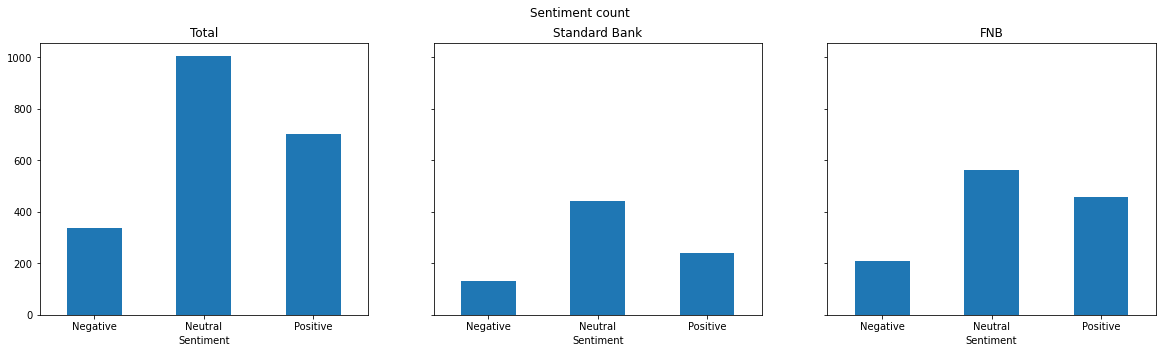

In [35]:
#set graph values
sentimentFinal = Final_df[["Bank","Sentiment"]].groupby('Sentiment').count()["Bank"]
sentimentStd = standard_df[["Bank","Sentiment"]].groupby('Sentiment').count()["Bank"]
sentimentFNB = FNB_df[["Bank","Sentiment"]].groupby('Sentiment').count()["Bank"]

#create graphs
fig, axes = plt.subplots(1, 3,figsize=(20, 5),sharey=True)
fig.suptitle('Sentiment count')

sentimentFinal.plot(ax = axes[0],kind='bar', title='Total',rot= 0)
sentimentStd.plot(ax = axes[1], kind='bar', title='Standard Bank',rot= 0)
sentimentFNB.plot(ax = axes[2], kind='bar', title='FNB',rot= 0)
plt.show()

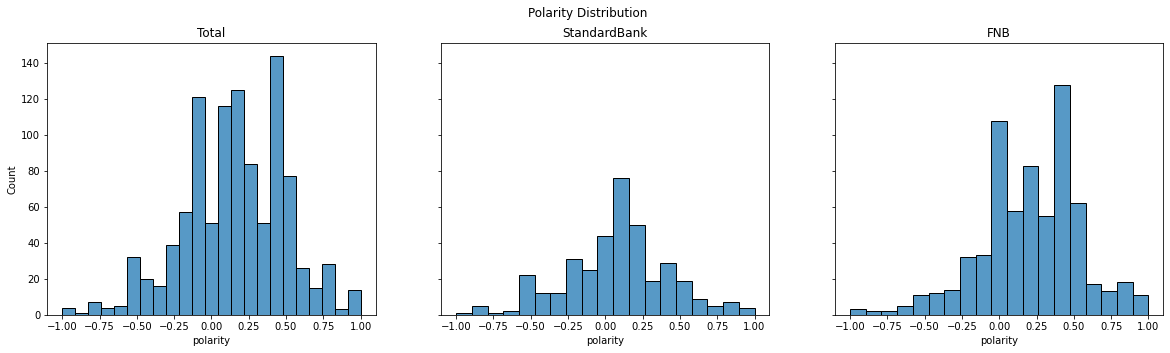

In [36]:
fig, axes = plt.subplots(1, 3,figsize=(20, 5),sharey=True)
fig.suptitle('Polarity Distribution')

# FNB
sns.histplot(ax=axes[0], data = Final_df['polarity'][~(Final_df['polarity']==0)])
axes[0].set_title("Total")

#StandardBank
sns.histplot(ax=axes[1], data= standard_df['polarity'][~(standard_df['polarity']==0)])
axes[1].set_title("StandardBank")

# FNB
sns.histplot(ax=axes[2], data = FNB_df['polarity'][~(FNB_df['polarity']==0)])
axes[2].set_title("FNB")
plt.show()

# Hashtag analysis 

In [41]:
#### Top 5 hastags 

In [42]:
import ast
from collections import Counter

#get all hashtags as list
def hashlist(df):
    hashlist = []
    for i in df['hashtags']:
        hashlist.extend(ast.literal_eval(i))
    return hashlist

#Create values
def Create_values(hashlist):
    labels, values = zip(*Counter(hashlist).most_common(5))
    indexes = np.arange(len(labels))
    return labels,indexes,values

t_labels,t_indexes,t_values = Create_values(hashlist(Final_df))
s_labels,s_indexes,s_values = Create_values(hashlist(standard_df))
f_labels,f_indexes,f_values = Create_values(hashlist(FNB_df))

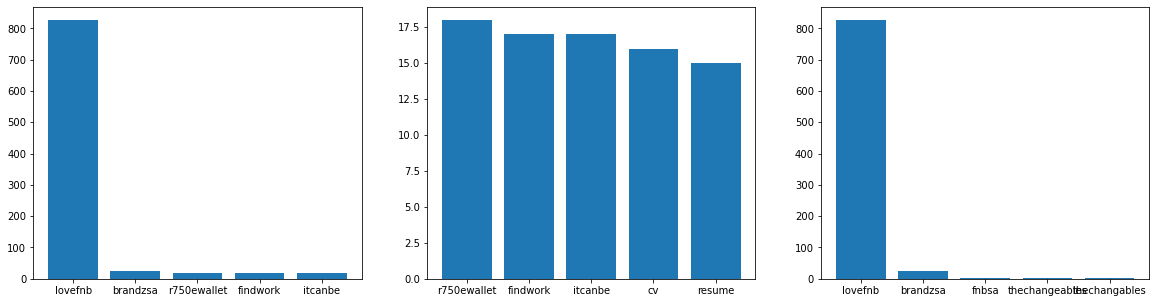

In [43]:
#plot graphs
fig, axes = plt.subplots(1, 3,figsize=(20, 5))

axes[0].bar(t_indexes, t_values )
axes[0].set_xticks(np.arange(len(t_labels)))
axes[0].set_xticklabels(t_labels)

axes[1].bar(s_indexes, s_values )
axes[1].set_xticks(np.arange(len(s_labels)))
axes[1].set_xticklabels(s_labels)

axes[2].bar(f_indexes, f_values )
axes[2].set_xticks(np.arange(len(f_labels)))
axes[2].set_xticklabels(f_labels)
plt.show()

# Word Cloud

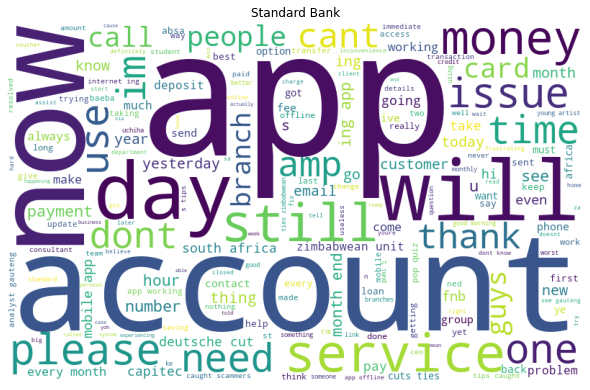

In [45]:
tweetString = " ".join(list(standard_df["cleaned_tweet"])).lower()
tweetString1 = re.sub(r"standardbankza|standard bank|bank","",tweetString)     #remove bank name

wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString1)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

plt.axis("off")
plt.title("Standard Bank")
plt.tight_layout(pad = 0) 
plt.show()

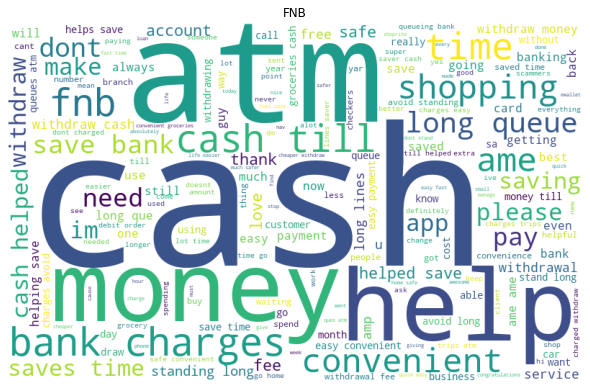

In [46]:
Fnb_string = " ".join(list(FNB_df["cleaned_tweet"])).lower()

wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(Fnb_string)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("FNB")
plt.tight_layout(pad = 0) 
plt.show()

# Rolling plots

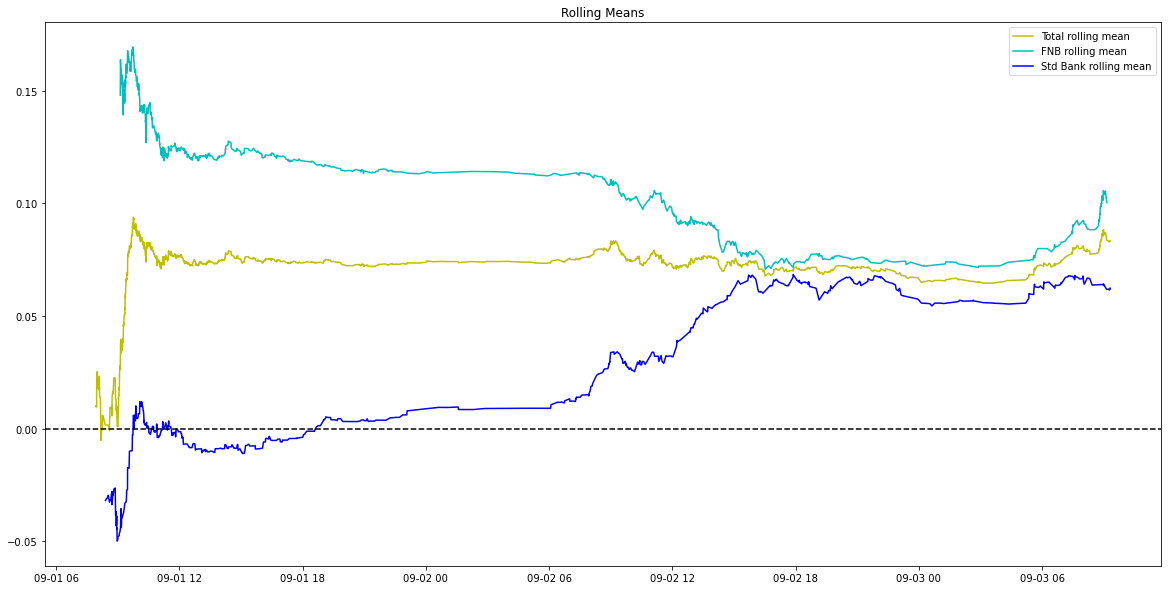

In [70]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(Final_df.iloc[50:].index,Final_df['rolling'].iloc[50:], color='y', label='Total rolling mean')
ax.plot(FNB_df.iloc[50:].index,FNB_df.iloc[50:]['rolling'], color ='c', label='FNB rolling mean')
ax.plot(standard_df.iloc[50:].index,standard_df.iloc[50:]['rolling'], color ='b', label='Std Bank rolling mean')
plt.axhline(y = 0, color = 'k', linestyle = 'dashed')
plt.legend()
plt.title("Rolling Means")
plt.show()

In [71]:
Final_df.to_csv("Final.csv")

# To do 

1. Graph sentiment per day / month 

https://medium.com/analytics-vidhya/utilizing-twint-and-textblob-for-scraping-and-sentimenet-analysis-of-caucasianjamess-tweets-c1c548f52bbb

2. Check textblob - can I improve the sentiment score

3. get outages overlap to rolling mean